In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

In [2]:
'''helper function to display images'''
def display_images(images,titles,row,col):
    fig = plt.figure(figsize = (20,20))
    for i in range(len(images)):
        fig.add_subplot(row,col,i + 1)
        #RGB
        if np.ndim(images[i]) == 3:
            plt.imshow(images[i])
        else:
            plt.imshow(images[i],cmap = 'gray')
        plt.title(titles[i])
        plt.axis("off")
    

(1440, 1080, 3)
(1440, 1080, 3)


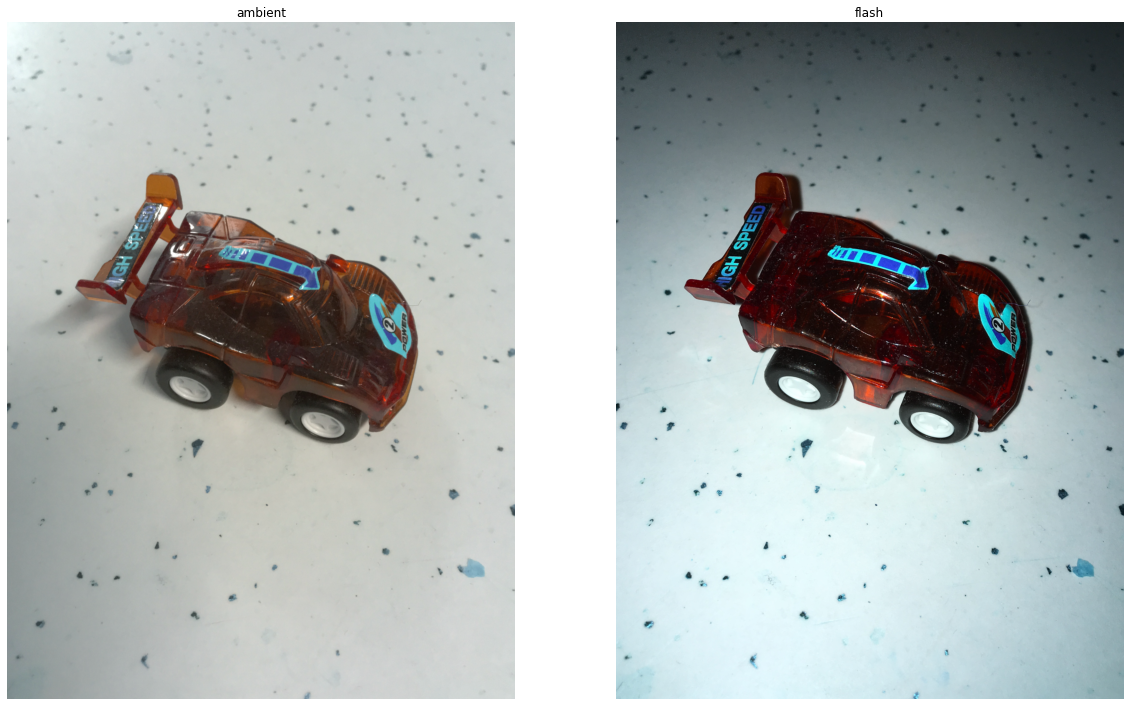

In [3]:
''' load the a pair of flash and no flash image '''
flash = cv2.imread("./../data/Objects_002_flash.png",cv2.IMREAD_UNCHANGED)
ambient = cv2.imread("./../data/Objects_002_ambient.png",cv2.IMREAD_UNCHANGED)
display_images([ambient,flash],['ambient','flash'],1,2)

print(flash.shape)
print(ambient.shape)

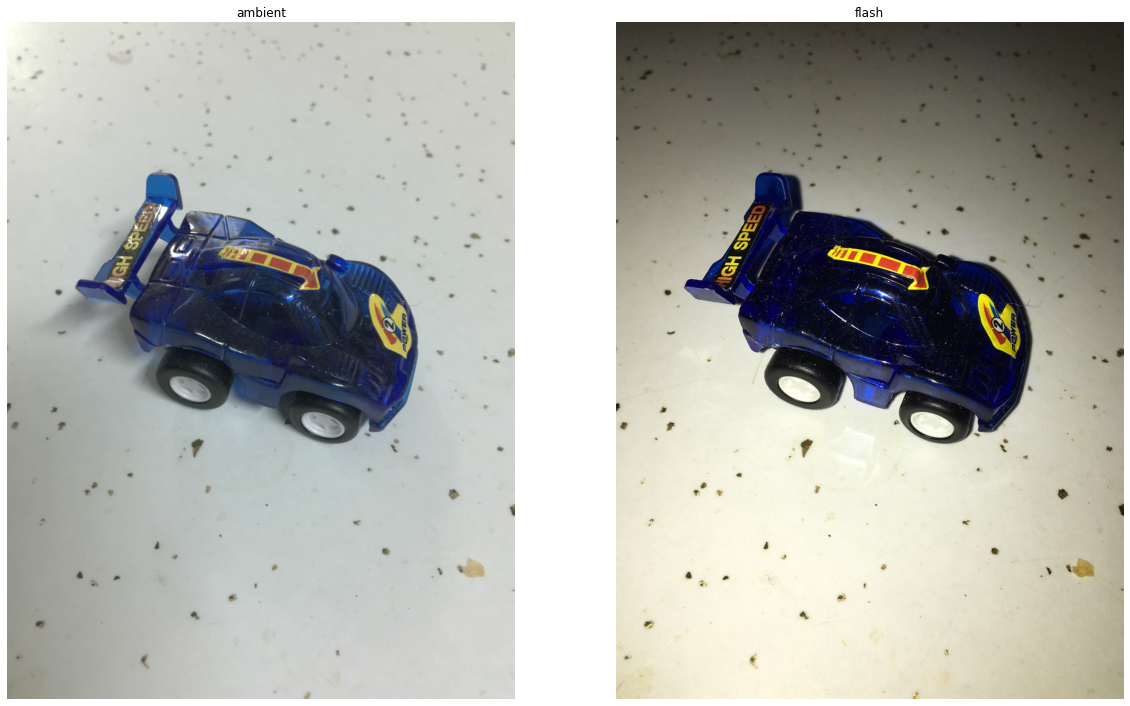

In [4]:
''' convert to RGB '''
flash = cv2.cvtColor(flash,cv2.COLOR_BGR2RGB)
ambient = cv2.cvtColor(ambient,cv2.COLOR_BGR2RGB)
display_images([ambient,flash],['ambient','flash'],1,2)



$$ \textbf{Implementing Bayesian Matting First ,then Extending it to Joint Bayesian Flash Matting }$$


## REFERENCES

[1] Yung-Yu Chuang, Brian Curless, David H. Salesin, and Richard Szeliski. A Bayesian Approach to Digital Matting. In _Proceedings of IEEE Computer Vision and Pattern Recognition (CVPR 2001)_, Vol. II, 264-271, December 2001

In [5]:
''' function load a input image,trimap and Ground truth for an image and display the images '''
def load_images(name):
    image = cv2.imread("./../data_2/images/" + name,cv2.IMREAD_UNCHANGED)
    trimap = cv2.imread("./../data_2/trimaps/" + name,cv2.IMREAD_UNCHANGED)
    ground_truth = cv2.imread("./../data_2/ground_truths/" + name,cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    trimap = cv2.cvtColor(trimap,cv2.COLOR_BGR2GRAY)
    ground_truth = cv2.cvtColor(ground_truth,cv2.COLOR_BGR2GRAY)
    display_images([image,trimap,ground_truth],["image","trimap","ground truth"],3,1)
    return image,trimap,ground_truth

        
    

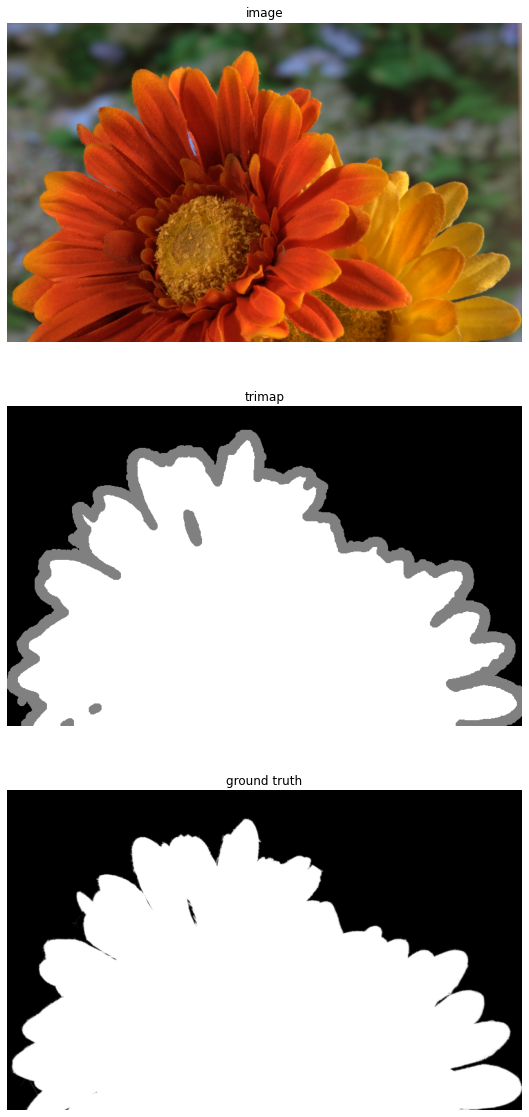

In [6]:
im,tr,gt = load_images("GT01.png")

In [7]:
''' helper function to divide the trimap into surely foreground and surely background and unknown region'''
def get_maps(trimap):
    bg = np.copy(trimap.astype(np.uint8))
    fg = np.copy(trimap.astype(np.uint8))
    un = np.copy(trimap.astype(np.uint8))
    bg[trimap != 0] = 0
    bg[trimap == 0] = 255
    fg[trimap != 255] = 0
    un[trimap == 128] = 255
    un[trimap != 128] = 0
    return bg,fg,un

    

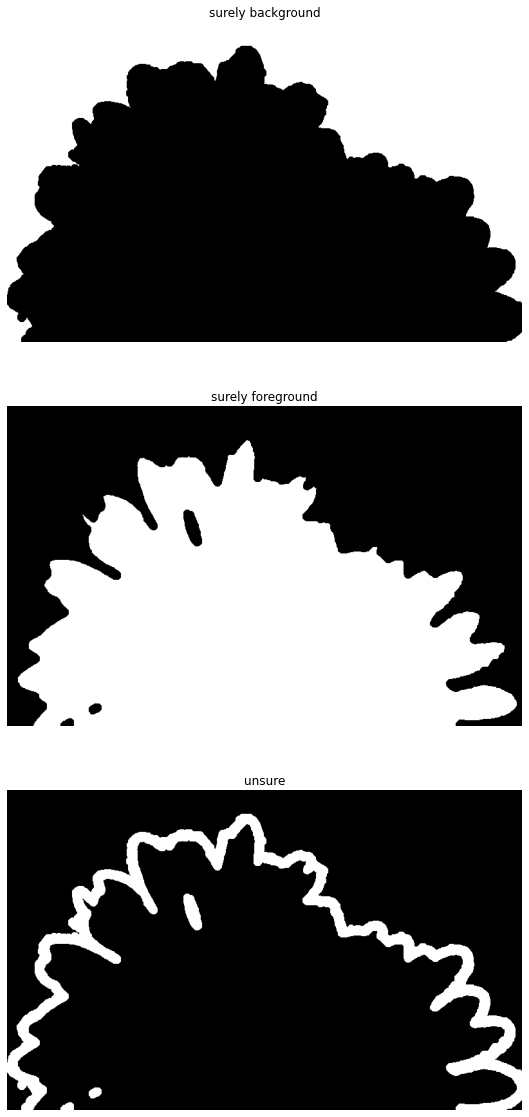

In [8]:
bg,fg,un = get_maps(tr)
display_images([bg,fg,un],["surely background","surely foreground","unsure"],3,1)

In [9]:
''' create a gaussian kernel of size k with sigma '''
def create_gaussian(k,sigma):
    return np.dot(cv2.getGaussianKernel(k,sigma),cv2.getGaussianKernel(k,sigma).T)


In [10]:
''' helper to zero pad the image '''
def pad_image(img,pad_x,pad_y):
    #grayscale
    if(np.ndim(img) == 2):
        (l,b) = img.shape
        new_image = np.zeros((l + 2 * pad_y, b + 2 * pad_x),dtype = np.uint8)
        new_image[pad_y : pad_y + l,pad_x : pad_x + b] = img
        return new_image
    #RGB
    else:
        (l,b,h) = img.shape
        new_image = np.zeros((l + 2 * pad_y, b + 2 * pad_x , h),dtype = np.uint8)
        new_image[pad_y : pad_y + l,pad_x : pad_x + b,:] = img
        return new_image
    
        
        

In [11]:
''' helper function to get neighbourhood '''
''' assuming the height and width to be odd for convenience'''
''' to do handle exceptions for now assuming its correct'''
def get_neighbourhood(img,centre_y,centre_x,height ,width ):
    ''' grayscale'''
    #print(np.ndim(img))
    if(np.ndim(img) == 2):
        pad_x = width // 2
        pad_y = height // 2
        padded_img = pad_image(img,pad_x,pad_y)
        (l,b) = img.shape
        left = centre_x - width // 2
        right = centre_x + width // 2
        up = centre_y - height // 2
        down = centre_y + height // 2
        return padded_img[up : down + 1,left : right + 1]
   
    elif np.ndim(img) == 3:
        
        (l,b,h) = img.shape
        pad_x = width // 2
        pad_y = height // 2
        padded_img = pad_image(img,pad_x,pad_y)
        left = centre_x - width // 2
        right = centre_x + width // 2
        up = centre_y - height // 2
        down = centre_y + height // 2
        #print(left,right,up,down)
        return padded_img[up : down + 1,left : right + 1,:]
    
        
    
    

In [60]:

#clusters the neighbourhood around a location and tries to compute the mean and convariance for each

def getMeanandCovariance(pixels,kernel,num_cluster = 5):
    #print("MEAN ")
    #print(pixels.shape)
    #shape of the pixels is (N,3) where N is the valid foreground/background pixels
    means = []
    Covs = []
    clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
    labels = np.array(clusters.predict(pixels))
    for i in range(num_cluster):
        group = (labels == i) #truth array of the pixels withing the cluster
        this_pixels = np.asarray(pixels[group]) #pixel values of the cluster
        kernel_bin = np.reshape(kernel[group], (kernel[group].size,1)) #reshape the weights to the this_pixel
        kernel_sqrt = np.sqrt(kernel_bin) # useful for covariance computing

        #compute the weighted mean
        #compute the mean for each channel individually
        meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
                            np.dot(this_pixels[:,2], kernel_bin)])/np.sum(kernel_bin)
        #print("mean shape : {0} this_pixels shape : {1} kernel_bin.shape : {2}".format(meanbin.shape,this_pixels.shape,kernel_bin.shape))
        meanbin = np.reshape(meanbin, (3,))
        means.append(meanbin)

        diff = (this_pixels - meanbin)
        diff = np.multiply(kernel_sqrt, diff)
        covbin = np.eye(3)
        with np.errstate(divide='raise'): # raise errors, but dont stop execution when low number of clusters, and other cases
            try:
                covbin = np.dot(diff.T, diff)/(np.sum(kernel_bin) + 0.00001) + np.eye(3)*(10**(-5)) #adding small value to prevent singular matrices
            except Exception as e:
                print("Error")
                print(covbin.shape)
            #print("Maybe")
            #print(covbin)
        Covs.append(covbin)  
    means = np.array(means).T
    Covs = np.array(cv2.merge(Covs)) #merge 3 channels to 1
    #means have shape (3,K) K is the number of cluster
    #Covs have the shape (3,3,K) where K is the number of cluster
    #print(means.shape,Covs.shape,num_cluster)
    return means, Covs
        
        
    
    

In [61]:
'''
Solves the matting Equations Iteratively
Choose the best pair of (FG,BG) which maximizes the likelyhood of a given F,B,alpha
returns the value of F,B, alpha
'''
def Solver(fgmean, fgCov, bgmean, bgCov, Cmean, CCov, initial_Alpha,  minLikelihoodDelta = 10**(-3), maxIterations = 10):
    #means have shape (3,K) K is the number of cluster
    #Covs have the shape (3,3,K) where K is the number of cluster
    #CMean is a [a,b,c]
    #CCov is a scaler
    #initial_Alpha is a float
    #Some global required constants
    z,num_cluster = fgmean.shape
    solved_fg = np.zeros(3)
    solved_bg = np.zeros(3)
    solved_alpha = 0
    I = np.eye(3)
    nIterations = 0
    maxLikelihood = - np.inf
    
    for i in range(num_cluster):
        try:
            invCovF = np.linalg.inv(fgCov[:,:,i]) # compute inverse of the FG convariance matrix
        except Exception as e: # maynot be singular
            print("The Foreground matrix is not singular,Skipping for now")
            continue

        cur_fgmean = fgmean[:, i] #mean of ith FG Cluster 1*3

        for j in range(num_cluster):
            try:
                invCovB = np.linalg.inv(bgCov[:,:,j]) # compute inverse of the BG convariance matrix
            except Exception as e: # Sometimes its singular, so we dump the matrix and skip for now!
                print("The Background matrix is not singular,Skipping for now")
                continue
                

            cur_bgmean = bgmean[:, j] #mean of ith BG Cluster

            #Initialization for the iterative solver
            alpha = initial_Alpha
            nIterations = 0
            prevLikelihood = -np.inf
            while True:
                nIterations += 1

                #SOLVE THE EQUATION DESCRIBED IN THE PAPER

                #define A
                a11 = invCovF + I*(alpha/CCov)**2  #3X3
                a12 = I*(alpha*(1-alpha)/(CCov)**2) # 3X3
                a22 = invCovB + I*((1 - alpha)/CCov)**2 #3X3
                r1 = np.hstack((a11, a12)) #create the top row 3*6
                r2 = np.hstack((a12, a22)) # create the bottom row 3*6
                A = np.vstack((r1, r2)) #create the final matrix 6*6

                #define b
                b11 = np.dot(invCovF, cur_fgmean) + Cmean*(alpha/CCov**2)  # 3*1
                b12 = np.dot(invCovB, cur_bgmean) + Cmean*(1-alpha)/(CCov**2) # 3*1
                b = np.concatenate((b11, b12)).T #(6,)

                #solve Ax = b
                try:
                    x = np.linalg.solve(A, b)
                except Exception as e: # Sometimes there is an issue with solving if A is non invertible. This did not occur after singular matrices were skipped, but is still there for safety.
                    print("ERROR SOLVING")
                    break


                #assign fg and bg that are solved
                fgCol = x[0:3]
                bgCol = x[3:6]

                # SOLVE FOR ALPHA using estimated F, B, C        
                alpha = np.dot((Cmean.T - bgCol).T, (fgCol - bgCol))/(np.sum(np.square(fgCol - bgCol))) #float

                #clip Alpha
                if alpha < 0:
                      alpha = 0
                if alpha > 1:
                      alpha = 1


                # Compute Likelyhood
                
                #L[0] = -np.sum((Cmean.T - alpha*fgCol - (1-alpha)*bgCol)**2)/(colCov**2) # L(C|F,B, alpha)
                L1 = -(np.linalg.norm((Cmean.T - alpha*fgCol - (1-alpha)*bgCol),2)**2)/(CCov**2) # L(C|F,B, alpha)
                LF = -(np.dot(np.dot((fgCol - cur_fgmean.T).T, invCovF), (fgCol - cur_fgmean.T).T)/2) #L(F)
                LB = -(np.dot(np.dot((bgCol - cur_bgmean.T).T, invCovB), (bgCol - cur_bgmean.T).T)/2) #L(B)
                L = np.array([L1,LF,LB])

                likelihood = np.sum(L)

                if likelihood > maxLikelihood: # If best likelihood so far, use that
                    solved_alpha = alpha
                    maxLikelihood = likelihood
                    solved_fg = fgCol
                    solved_bg = bgCol

                # Stop solving if the solver saturates or if it exceeds the maximum number of iterations per cluster pair
                if abs(prevLikelihood - likelihood) < minLikelihoodDelta or nIterations > maxIterations: # Stop solving
                    break

                prevLikelihood = likelihood

        return solved_fg,solved_bg, solved_alpha

In [62]:
def solve(im,trimap,gt,thresh = 10):
    # get the regions for each type
    bg,fg,unk = get_maps(trimap)
    y,x = np.where(unk != 0) # locations where classification is unknown
    unsolved_loc = list(set(zip(y,x)))
    unsolved_loc = sorted(unsolved_loc,key = lambda x : x[0]) #top to bottom
    # this is essentially the alpha matrix
    # 1 for foreground pixels
    # 0 for background pixels
    # nan for unknowns.
    mask = np.copy(unk).astype(np.float64)
    
   
    
    mask[unk != 0] = np.nan #replace unknown regions with nan
    mask[fg != 0] = 1 #replace foreground region with 1
    
    #print("mask")
    #print("mask unique")
    #print(np.unique(mask))
    #print(mask)
    #print(mask.shape)
    #print("")
    
    #convert fg to RGB

    fg1 = np.zeros((im.shape))
    fg1[:,:,0] = fg
    fg1[:,:,1] = fg
    fg1[:,:,2] = fg
    #convert bg to RGB for bitwise operations
    bg1 = np.zeros((im.shape))
    bg1[:,:,0] = bg
    bg1[:,:,1] = bg
    bg1[:,:,2] = bg

    #generate surely background and surely foreground images
    f = cv2.bitwise_and(fg1.astype(np.uint8),im.astype(np.uint8))
    b = cv2.bitwise_and(bg1.astype(np.uint8),im.astype(np.uint8))
    #display_images([f,b,im],["foreground","background","original"],3,1)
    
    iteration = 0
    solved = []
    tosolve = np.copy(unsolved_loc)
    sad_score = 0
    pass_num = 0
    pass_thresh = 5
    window_size = 19
    sigma = 10
    while(len(tosolve) > 0):
        pass_num += 1
        tosolve = []
        #create a list of locations to be solved
        for loc in unsolved_loc :
            #check it is not already solved
            if loc not in solved:
                tosolve.append(loc)
        if pass_num > pass_thresh and pass_num % 3:
            window_size += 2 #initally odd,remains odd.Window size increases when too many unknowns
        print("PASS NUMBER : {0} , WINDOW SIZE : {1}".format(pass_num,window_size))
        for loc in tosolve:
            gaussian_kernel = create_gaussian(window_size,sigma) #create kernel
            alpha = get_neighbourhood(mask,loc[0],loc[1],window_size,window_size)
            #print("alpha")
            #print(alpha)
            #print(alpha.shape)
            
            #find fg  pixels for clustering
            kernel_f = np.multiply(np.square(alpha),gaussian_kernel)
            fg_window = get_neighbourhood(f,loc[0],loc[1],window_size,window_size)
            #print("window size")
            #print(fg_window)
            #print(fg_window.shape)
            
            known = np.nan_to_num(kernel_f) > 0 #return a boolean array with true values for non-zero and non-nan values
            fg_pixel = fg_window[known] #extract the selected pixel location
            #print("fg_pixel")
            #print(fg_pixel)
            #print(fg_pixel.shape)
            #print("fg_pixel.shape")
            kernel_f = kernel_f[known] # extract the selected pixel location
            
            #find  bg pixels for clustering
            kernel_b = np.multiply(np.square(1- alpha),gaussian_kernel)
            bg_window = get_neighbourhood(b,loc[0],loc[1],window_size,window_size)
            known = np.nan_to_num(kernel_b) > 0 #return a boolean array with true values for non-zero and non-nan values
            bg_pixel = bg_window[known] #extract the selected pixel location
            kernel_b = kernel_b[known] # extract the selected pixel location
            
            '''
            print("Check")
            print(fg_pixel)
            print(fg_pixel.shape)
            #print
            print(bg_pixel)
            print(bg_pixel.shape)
            print("")
            '''
            
            #check sufficient data to solve the proble
            if(len(fg_pixel) >= thresh and len(bg_pixel) >= thresh):
                    
                #print("Check")
                #print(fg_pixel)
                #print(fg_pixel.shape)
                #print
                #print(bg_pixel)
                #print(bg_pixel.shape)
                #print("")
                
                fgmean,fgCov = getMeanandCovariance(fg_pixel,kernel_f,num_cluster = 5)
                bgmean,bgCov = getMeanandCovariance(bg_pixel,kernel_b,num_cluster = 5)
                
                #observed_c
                Cmean = im[loc[0],loc[1],:]
                CCov = 3 #tunable parameter
                #print(Cmean,CCov)
                
                #take intial guess as mean
                initial_alpha = np.nanmean(alpha)
                
                #print(initial_alpha)
                
                
                #iteratively solve!
                final_fg, final_bg, final_alpha = Solver(fgmean, fgCov, bgmean, bgCov, Cmean, CCov, initial_alpha, maxIterations = 50)


                #update the estimated values
                
                #print(final_fg,final_bg,final_alpha)
                mask[loc[0],loc[1]] = final_alpha
                f[loc[0],loc[1],:] = np.array(final_fg)
                b[loc[0],loc[1],:] = np.array(final_bg)
                solved.append(loc)


                #print occasional status updates
                if iteration % 10 == 0:
                    print("PASS : ", pass_num)
                    print("WINDOW SIZE = ", window_size)
                    print('SOLVED LOCATIONS = ', len(solved))
                    print('REMAINING LOCATIONS = ', len(tosolve) - len(solved))
                    #sad = np.sum(np.absolute((cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY)/255).astype(np.float) - np.nan_to_num(mask)))
                    #print('SAD = ', sad)
                    print('---------------------------------------------')
                    final_alpha = cv2.cvtColor((mask*255).astype(np.uint8), cv2.COLOR_GRAY2BGR) #3 c
                    #showMultiImages((fg, bg, gt, alpha3channel), 'CURRENT')


                iteration += 1
    sad = np.sum(np.absolute((cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY )/255).astype(np.float) - np.nan_to_num(mask)))
    print('SOLVER COMPLETED IN ', iterations, 'ITERATIONS')
    print('---------------------------------------------')
    print('---------------------------------------------')
    print('---------------------------------------------')


    return f, b, mask
                
                
            
            
            
        
    
    

PASS NUMBER : 1 , WINDOW SIZE : 19
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1
REMAINING LOCATIONS =  38572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11
REMAINING LOCATIONS =  38562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  21
REMAINING LOCATIONS =  38552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  31
REMAINING LOCATIONS =  38542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  41
REMAINING LOCATIONS =  38532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  51
REMAINING LOCATIONS =  38522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  61
REMAINING LOCATIONS =  38512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  71
REMAINING LOCATIONS =  38502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  81
REMAINING LOCATIONS =  38492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  91
REMAINING LOCATIONS =  38482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  101
REMAINING LOCATIONS =  38472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  111
REMAINING LOCATIONS =  38462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  121
REMAINING LOCATIONS =  38452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  131
REMAINING LOCATIONS =  38442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  141
REMAINING LOCATIONS =  38432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  151
REMAINING LOCATIONS =  38422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  161
REMAINING LOCATIONS =  38412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  171
REMAINING LOCATIONS =  38402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  181
REMAINING LOCATIONS =  38392
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  191
REMAINING LOCATIONS =  38382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  201
REMAINING LOCATIONS =  38372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  211
REMAINING LOCATIONS =  38362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  221
REMAINING LOCATIONS =  38352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  231
REMAINING LOCATIONS =  38342
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  241
REMAINING LOCATIONS =  38332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  251
REMAINING LOCATIONS =  38322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  261
REMAINING LOCATIONS =  38312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  271
REMAINING LOCATIONS =  38302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  281
REMAINING LOCATIONS =  38292
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  291
REMAINING LOCATIONS =  38282
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  301
REMAINING LOCATIONS =  38272
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  311
REMAINING LOCATIONS =  38262
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  321
REMAINING LOCATIONS =  38252
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  331
REMAINING LOCATIONS =  38242
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  341
REMAINING LOCATIONS =  38232
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  351
REMAINING LOCATIONS =  38222
------------------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  501
REMAINING LOCATIONS =  38072
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  511
REMAINING LOCATIONS =  38062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  521
REMAINING LOCATIONS =  38052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  531
REMAINING LOCATIONS =  38042
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  541
REMAINING LOCATIONS =  38032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  551
REMAINING LOCATIONS =  38022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  561
REMAINING LOCATIONS =  38012
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  571
REMAINING LOCATIONS =  38002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  581
REMAINING LOCATIONS =  37992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  591
REMAINING LOCATIONS =  37982
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  601
REMAINING LOCATIONS =  37972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  611
REMAINING LOCATIONS =  37962
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  621
REMAINING LOCATIONS =  37952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  631
REMAINING LOCATIONS =  37942
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  641
REMAINING LOCATIONS =  37932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  651
REMAINING LOCATIONS =  37922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  661
REMAINING LOCATIONS =  37912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  671
REMAINING LOCATIONS =  37902
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  681
REMAINING LOCATIONS =  37892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  691
REMAINING LOCATIONS =  37882
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  701
REMAINING LOCATIONS =  37872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  711
REMAINING LOCATIONS =  37862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  721
REMAINING LOCATIONS =  37852
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  731
REMAINING LOCATIONS =  37842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  741
REMAINING LOCATIONS =  37832
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  751
REMAINING LOCATIONS =  37822
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  761
REMAINING LOCATIONS =  37812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  771
REMAINING LOCATIONS =  37802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  781
REMAINING LOCATIONS =  37792
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  791
REMAINING LOCATIONS =  37782
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  801
REMAINING LOCATIONS =  37772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  811
REMAINING LOCATIONS =  37762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  821
REMAINING LOCATIONS =  37752
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  831
REMAINING LOCATIONS =  37742
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  841
REMAINING LOCATIONS =  37732
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  851
REMAINING LOCATIONS =  37722
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  861
REMAINING LOCATIONS =  37712
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  871
REMAINING LOCATIONS =  37702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  881
REMAINING LOCATIONS =  37692
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  891
REMAINING LOCATIONS =  37682
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  901
REMAINING LOCATIONS =  37672
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  911
REMAINING LOCATIONS =  37662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  921
REMAINING LOCATIONS =  37652
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  931
REMAINING LOCATIONS =  37642
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  941
REMAINING LOCATIONS =  37632
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  951
REMAINING LOCATIONS =  37622
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  961
REMAINING LOCATIONS =  37612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  971
REMAINING LOCATIONS =  37602
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  981
REMAINING LOCATIONS =  37592
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  991
REMAINING LOCATIONS =  37582
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1001
REMAINING LOCATIONS =  37572
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1011
REMAINING LOCATIONS =  37562
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1021
REMAINING LOCATIONS =  37552
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1031
REMAINING LOCATIONS =  37542
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1041
REMAINING LOCATIONS =  37532
-------------------------

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1621
REMAINING LOCATIONS =  36952
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1631
REMAINING LOCATIONS =  36942
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1641
REMAINING LOCATIONS =  36932
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1651
REMAINING LOCATIONS =  36922
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1661
REMAINING LOCATIONS =  36912
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1671
REMAINING LOCATIONS =  36902
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1681
REMAINING LOCATIONS =  36892
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1691
REMAINING LOCATIONS =  36882
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1811
REMAINING LOCATIONS =  36762
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1821
REMAINING LOCATIONS =  36752
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1831
REMAINING LOCATIONS =  36742
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1841
REMAINING LOCATIONS =  36732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1851
REMAINING LOCATIONS =  36722
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1861
REMAINING LOCATIONS =  36712
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1871
REMAINING LOCATIONS =  36702
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1881
REMAINING LOCATIONS =  36692
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1891
REMAINING LOCATIONS =  36682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1901
REMAINING LOCATIONS =  36672
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1911
REMAINING LOCATIONS =  36662
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1921
REMAINING LOCATIONS =  36652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1931
REMAINING LOCATIONS =  36642
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1941
REMAINING LOCATIONS =  36632
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1951
REMAINING LOCATIONS =  36622
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1961
REMAINING LOCATIONS =  36612
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1971
REMAINING LOCATIONS =  36602
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1981
REMAINING LOCATIONS =  36592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  1991
REMAINING LOCATIONS =  36582
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2001
REMAINING LOCATIONS =  36572
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2011
REMAINING LOCATIONS =  36562
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2021
REMAINING LOCATIONS =  36552
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2031
REMAINING LOCATIONS =  36542
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2041
REMAINING LOCATIONS =  36532
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2051
REMAINING LOCATIONS =  36522
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2061
REMAINING LOCATIONS =  36512
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2081
REMAINING LOCATIONS =  36492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2091
REMAINING LOCATIONS =  36482
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2101
REMAINING LOCATIONS =  36472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2111
REMAINING LOCATIONS =  36462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2121
REMAINING LOCATIONS =  36452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2131
REMAINING LOCATIONS =  36442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2141
REMAINING LOCATIONS =  36432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2151
REMAINING LOCATIONS =  36422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2161
REMAINING LOCATIONS =  36412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2171
REMAINING LOCATIONS =  36402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2181
REMAINING LOCATIONS =  36392
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2191
REMAINING LOCATIONS =  36382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2201
REMAINING LOCATIONS =  36372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2211
REMAINING LOCATIONS =  36362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2221
REMAINING LOCATIONS =  36352
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2231
REMAINING LOCATIONS =  36342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2241
REMAINING LOCATIONS =  36332
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2251
REMAINING LOCATIONS =  36322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2261
REMAINING LOCATIONS =  36312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2271
REMAINING LOCATIONS =  36302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2281
REMAINING LOCATIONS =  36292
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2291
REMAINING LOCATIONS =  36282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2301
REMAINING LOCATIONS =  36272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2311
REMAINING LOCATIONS =  36262
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2321
REMAINING LOCATIONS =  36252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2331
REMAINING LOCATIONS =  36242
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2341
REMAINING LOCATIONS =  36232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2351
REMAINING LOCATIONS =  36222
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2361
REMAINING LOCATIONS =  36212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2371
REMAINING LOCATIONS =  36202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2381
REMAINING LOCATIONS =  36192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2391
REMAINING LOCATIONS =  36182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2401
REMAINING LOCATIONS =  36172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2411
REMAINING LOCATIONS =  36162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2421
REMAINING LOCATIONS =  36152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2431
REMAINING LOCATIONS =  36142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2441
REMAINING LOCATIONS =  36132
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2451
REMAINING LOCATIONS =  36122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2461
REMAINING LOCATIONS =  36112
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2471
REMAINING LOCATIONS =  36102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2481
REMAINING LOCATIONS =  36092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2491
REMAINING LOCATIONS =  36082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2501
REMAINING LOCATIONS =  36072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2511
REMAINING LOCATIONS =  36062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2521
REMAINING LOCATIONS =  36052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2531
REMAINING LOCATIONS =  36042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2541
REMAINING LOCATIONS =  36032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2551
REMAINING LOCATIONS =  36022
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2561
REMAINING LOCATIONS =  36012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2571
REMAINING LOCATIONS =  36002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2581
REMAINING LOCATIONS =  35992
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2591
REMAINING LOCATIONS =  35982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2601
REMAINING LOCATIONS =  35972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2611
REMAINING LOCATIONS =  35962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2621
REMAINING LOCATIONS =  35952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2631
REMAINING LOCATIONS =  35942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2641
REMAINING LOCATIONS =  35932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2651
REMAINING LOCATIONS =  35922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2661
REMAINING LOCATIONS =  35912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2671
REMAINING LOCATIONS =  35902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2681
REMAINING LOCATIONS =  35892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2691
REMAINING LOCATIONS =  35882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2701
REMAINING LOCATIONS =  35872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2711
REMAINING LOCATIONS =  35862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2721
REMAINING LOCATIONS =  35852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2731
REMAINING LOCATIONS =  35842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2741
REMAINING LOCATIONS =  35832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2751
REMAINING LOCATIONS =  35822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2761
REMAINING LOCATIONS =  35812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2771
REMAINING LOCATIONS =  35802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2781
REMAINING LOCATIONS =  35792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2791
REMAINING LOCATIONS =  35782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2801
REMAINING LOCATIONS =  35772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2811
REMAINING LOCATIONS =  35762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2821
REMAINING LOCATIONS =  35752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2831
REMAINING LOCATIONS =  35742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2841
REMAINING LOCATIONS =  35732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2851
REMAINING LOCATIONS =  35722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2861
REMAINING LOCATIONS =  35712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2871
REMAINING LOCATIONS =  35702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2881
REMAINING LOCATIONS =  35692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2891
REMAINING LOCATIONS =  35682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2901
REMAINING LOCATIONS =  35672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2911
REMAINING LOCATIONS =  35662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2921
REMAINING LOCATIONS =  35652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2931
REMAINING LOCATIONS =  35642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2941
REMAINING LOCATIONS =  35632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2951
REMAINING LOCATIONS =  35622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2961
REMAINING LOCATIONS =  35612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2971
REMAINING LOCATIONS =  35602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2981
REMAINING LOCATIONS =  35592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  2991
REMAINING LOCATIONS =  35582
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3001
REMAINING LOCATIONS =  35572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3011
REMAINING LOCATIONS =  35562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3021
REMAINING LOCATIONS =  35552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3031
REMAINING LOCATIONS =  35542
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3041
REMAINING LOCATIONS =  35532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3051
REMAINING LOCATIONS =  35522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3061
REMAINING LOCATIONS =  35512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3071
REMAINING LOCATIONS =  35502
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3081
REMAINING LOCATIONS =  35492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3091
REMAINING LOCATIONS =  35482
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3101
REMAINING LOCATIONS =  35472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3111
REMAINING LOCATIONS =  35462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3121
REMAINING LOCATIONS =  35452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3131
REMAINING LOCATIONS =  35442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3141
REMAINING LOCATIONS =  35432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3151
REMAINING LOCATIONS =  35422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3161
REMAINING LOCATIONS =  35412
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3171
REMAINING LOCATIONS =  35402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3181
REMAINING LOCATIONS =  35392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3191
REMAINING LOCATIONS =  35382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3201
REMAINING LOCATIONS =  35372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3211
REMAINING LOCATIONS =  35362
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3221
REMAINING LOCATIONS =  35352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3231
REMAINING LOCATIONS =  35342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3241
REMAINING LOCATIONS =  35332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3251
REMAINING LOCATIONS =  35322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3261
REMAINING LOCATIONS =  35312
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3271
REMAINING LOCATIONS =  35302
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3281
REMAINING LOCATIONS =  35292
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3291
REMAINING LOCATIONS =  35282
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3301
REMAINING LOCATIONS =  35272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3311
REMAINING LOCATIONS =  35262
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3321
REMAINING LOCATIONS =  35252
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3331
REMAINING LOCATIONS =  35242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3341
REMAINING LOCATIONS =  35232
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3351
REMAINING LOCATIONS =  35222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3361
REMAINING LOCATIONS =  35212
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3371
REMAINING LOCATIONS =  35202
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3381
REMAINING LOCATIONS =  35192
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3391
REMAINING LOCATIONS =  35182
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3401
REMAINING LOCATIONS =  35172
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3411
REMAINING LOCATIONS =  35162
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3421
REMAINING LOCATIONS =  35152
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3431
REMAINING LOCATIONS =  35142
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3501
REMAINING LOCATIONS =  35072
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3511
REMAINING LOCATIONS =  35062
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3521
REMAINING LOCATIONS =  35052
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3531
REMAINING LOCATIONS =  35042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3541
REMAINING LOCATIONS =  35032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3551
REMAINING LOCATIONS =  35022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3561
REMAINING LOCATIONS =  35012
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3571
REMAINING LOCATIONS =  35002
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3581
REMAINING LOCATIONS =  34992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3591
REMAINING LOCATIONS =  34982
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3601
REMAINING LOCATIONS =  34972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3611
REMAINING LOCATIONS =  34962
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3621
REMAINING LOCATIONS =  34952
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3631
REMAINING LOCATIONS =  34942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3641
REMAINING LOCATIONS =  34932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3651
REMAINING LOCATIONS =  34922
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3661
REMAINING LOCATIONS =  34912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3671
REMAINING LOCATIONS =  34902
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3681
REMAINING LOCATIONS =  34892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3691
REMAINING LOCATIONS =  34882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3701
REMAINING LOCATIONS =  34872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3711
REMAINING LOCATIONS =  34862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3721
REMAINING LOCATIONS =  34852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3731
REMAINING LOCATIONS =  34842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3741
REMAINING LOCATIONS =  34832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3751
REMAINING LOCATIONS =  34822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3761
REMAINING LOCATIONS =  34812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3771
REMAINING LOCATIONS =  34802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3781
REMAINING LOCATIONS =  34792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3791
REMAINING LOCATIONS =  34782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3801
REMAINING LOCATIONS =  34772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3811
REMAINING LOCATIONS =  34762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3821
REMAINING LOCATIONS =  34752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3831
REMAINING LOCATIONS =  34742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3841
REMAINING LOCATIONS =  34732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3851
REMAINING LOCATIONS =  34722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3861
REMAINING LOCATIONS =  34712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3871
REMAINING LOCATIONS =  34702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3881
REMAINING LOCATIONS =  34692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3891
REMAINING LOCATIONS =  34682
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3901
REMAINING LOCATIONS =  34672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3911
REMAINING LOCATIONS =  34662
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3921
REMAINING LOCATIONS =  34652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3931
REMAINING LOCATIONS =  34642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3941
REMAINING LOCATIONS =  34632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3951
REMAINING LOCATIONS =  34622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3961
REMAINING LOCATIONS =  34612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3971
REMAINING LOCATIONS =  34602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3981
REMAINING LOCATIONS =  34592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  3991
REMAINING LOCATIONS =  34582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4001
REMAINING LOCATIONS =  34572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4011
REMAINING LOCATIONS =  34562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4021
REMAINING LOCATIONS =  34552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4031
REMAINING LOCATIONS =  34542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4041
REMAINING LOCATIONS =  34532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4051
REMAINING LOCATIONS =  34522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4061
REMAINING LOCATIONS =  34512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4071
REMAINING LOCATIONS =  34502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4081
REMAINING LOCATIONS =  34492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4091
REMAINING LOCATIONS =  34482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4101
REMAINING LOCATIONS =  34472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4111
REMAINING LOCATIONS =  34462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4121
REMAINING LOCATIONS =  34452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4131
REMAINING LOCATIONS =  34442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4141
REMAINING LOCATIONS =  34432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4151
REMAINING LOCATIONS =  34422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4161
REMAINING LOCATIONS =  34412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4171
REMAINING LOCATIONS =  34402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4181
REMAINING LOCATIONS =  34392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4191
REMAINING LOCATIONS =  34382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4201
REMAINING LOCATIONS =  34372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4211
REMAINING LOCATIONS =  34362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4221
REMAINING LOCATIONS =  34352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4231
REMAINING LOCATIONS =  34342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4241
REMAINING LOCATIONS =  34332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4251
REMAINING LOCATIONS =  34322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4261
REMAINING LOCATIONS =  34312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4271
REMAINING LOCATIONS =  34302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4281
REMAINING LOCATIONS =  34292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4291
REMAINING LOCATIONS =  34282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4301
REMAINING LOCATIONS =  34272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4311
REMAINING LOCATIONS =  34262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4321
REMAINING LOCATIONS =  34252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4331
REMAINING LOCATIONS =  34242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4341
REMAINING LOCATIONS =  34232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4351
REMAINING LOCATIONS =  34222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4361
REMAINING LOCATIONS =  34212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4371
REMAINING LOCATIONS =  34202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4381
REMAINING LOCATIONS =  34192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4391
REMAINING LOCATIONS =  34182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4401
REMAINING LOCATIONS =  34172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4411
REMAINING LOCATIONS =  34162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4421
REMAINING LOCATIONS =  34152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4431
REMAINING LOCATIONS =  34142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4441
REMAINING LOCATIONS =  34132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4451
REMAINING LOCATIONS =  34122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4461
REMAINING LOCATIONS =  34112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4471
REMAINING LOCATIONS =  34102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4481
REMAINING LOCATIONS =  34092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4491
REMAINING LOCATIONS =  34082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4501
REMAINING LOCATIONS =  34072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4511
REMAINING LOCATIONS =  34062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4521
REMAINING LOCATIONS =  34052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4531
REMAINING LOCATIONS =  34042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4541
REMAINING LOCATIONS =  34032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4551
REMAINING LOCATIONS =  34022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4561
REMAINING LOCATIONS =  34012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4571
REMAINING LOCATIONS =  34002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4581
REMAINING LOCATIONS =  33992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4591
REMAINING LOCATIONS =  33982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4601
REMAINING LOCATIONS =  33972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4611
REMAINING LOCATIONS =  33962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4621
REMAINING LOCATIONS =  33952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4631
REMAINING LOCATIONS =  33942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4641
REMAINING LOCATIONS =  33932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4651
REMAINING LOCATIONS =  33922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4661
REMAINING LOCATIONS =  33912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4671
REMAINING LOCATIONS =  33902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4681
REMAINING LOCATIONS =  33892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4691
REMAINING LOCATIONS =  33882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4701
REMAINING LOCATIONS =  33872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4711
REMAINING LOCATIONS =  33862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4721
REMAINING LOCATIONS =  33852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4731
REMAINING LOCATIONS =  33842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4741
REMAINING LOCATIONS =  33832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4751
REMAINING LOCATIONS =  33822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4761
REMAINING LOCATIONS =  33812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4771
REMAINING LOCATIONS =  33802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4781
REMAINING LOCATIONS =  33792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4791
REMAINING LOCATIONS =  33782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4801
REMAINING LOCATIONS =  33772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4811
REMAINING LOCATIONS =  33762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4821
REMAINING LOCATIONS =  33752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4831
REMAINING LOCATIONS =  33742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4841
REMAINING LOCATIONS =  33732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4851
REMAINING LOCATIONS =  33722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4861
REMAINING LOCATIONS =  33712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4871
REMAINING LOCATIONS =  33702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4881
REMAINING LOCATIONS =  33692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4891
REMAINING LOCATIONS =  33682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4901
REMAINING LOCATIONS =  33672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4911
REMAINING LOCATIONS =  33662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4921
REMAINING LOCATIONS =  33652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4931
REMAINING LOCATIONS =  33642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4941
REMAINING LOCATIONS =  33632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4951
REMAINING LOCATIONS =  33622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4961
REMAINING LOCATIONS =  33612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4971
REMAINING LOCATIONS =  33602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4981
REMAINING LOCATIONS =  33592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  4991
REMAINING LOCATIONS =  33582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5001
REMAINING LOCATIONS =  33572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5011
REMAINING LOCATIONS =  33562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5021
REMAINING LOCATIONS =  33552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5031
REMAINING LOCATIONS =  33542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5041
REMAINING LOCATIONS =  33532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5051
REMAINING LOCATIONS =  33522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5061
REMAINING LOCATIONS =  33512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5071
REMAINING LOCATIONS =  33502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5081
REMAINING LOCATIONS =  33492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5091
REMAINING LOCATIONS =  33482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5101
REMAINING LOCATIONS =  33472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5111
REMAINING LOCATIONS =  33462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5121
REMAINING LOCATIONS =  33452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5131
REMAINING LOCATIONS =  33442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5141
REMAINING LOCATIONS =  33432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5151
REMAINING LOCATIONS =  33422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5161
REMAINING LOCATIONS =  33412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5171
REMAINING LOCATIONS =  33402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5181
REMAINING LOCATIONS =  33392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5191
REMAINING LOCATIONS =  33382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5201
REMAINING LOCATIONS =  33372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5211
REMAINING LOCATIONS =  33362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5221
REMAINING LOCATIONS =  33352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5231
REMAINING LOCATIONS =  33342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5241
REMAINING LOCATIONS =  33332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5251
REMAINING LOCATIONS =  33322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5261
REMAINING LOCATIONS =  33312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5271
REMAINING LOCATIONS =  33302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5281
REMAINING LOCATIONS =  33292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5291
REMAINING LOCATIONS =  33282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5301
REMAINING LOCATIONS =  33272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5311
REMAINING LOCATIONS =  33262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5321
REMAINING LOCATIONS =  33252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5331
REMAINING LOCATIONS =  33242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5341
REMAINING LOCATIONS =  33232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5351
REMAINING LOCATIONS =  33222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5361
REMAINING LOCATIONS =  33212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5371
REMAINING LOCATIONS =  33202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5381
REMAINING LOCATIONS =  33192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5391
REMAINING LOCATIONS =  33182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5401
REMAINING LOCATIONS =  33172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5411
REMAINING LOCATIONS =  33162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5421
REMAINING LOCATIONS =  33152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5431
REMAINING LOCATIONS =  33142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5441
REMAINING LOCATIONS =  33132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5451
REMAINING LOCATIONS =  33122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5461
REMAINING LOCATIONS =  33112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5471
REMAINING LOCATIONS =  33102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5481
REMAINING LOCATIONS =  33092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5491
REMAINING LOCATIONS =  33082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5501
REMAINING LOCATIONS =  33072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5511
REMAINING LOCATIONS =  33062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5521
REMAINING LOCATIONS =  33052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5531
REMAINING LOCATIONS =  33042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5541
REMAINING LOCATIONS =  33032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5551
REMAINING LOCATIONS =  33022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5561
REMAINING LOCATIONS =  33012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5571
REMAINING LOCATIONS =  33002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5581
REMAINING LOCATIONS =  32992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5591
REMAINING LOCATIONS =  32982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5601
REMAINING LOCATIONS =  32972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5611
REMAINING LOCATIONS =  32962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5621
REMAINING LOCATIONS =  32952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5631
REMAINING LOCATIONS =  32942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5641
REMAINING LOCATIONS =  32932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5651
REMAINING LOCATIONS =  32922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5661
REMAINING LOCATIONS =  32912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5671
REMAINING LOCATIONS =  32902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5681
REMAINING LOCATIONS =  32892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5691
REMAINING LOCATIONS =  32882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5701
REMAINING LOCATIONS =  32872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5711
REMAINING LOCATIONS =  32862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5721
REMAINING LOCATIONS =  32852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5731
REMAINING LOCATIONS =  32842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5741
REMAINING LOCATIONS =  32832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5751
REMAINING LOCATIONS =  32822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5761
REMAINING LOCATIONS =  32812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5771
REMAINING LOCATIONS =  32802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5781
REMAINING LOCATIONS =  32792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5791
REMAINING LOCATIONS =  32782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5801
REMAINING LOCATIONS =  32772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5811
REMAINING LOCATIONS =  32762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5821
REMAINING LOCATIONS =  32752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5831
REMAINING LOCATIONS =  32742
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5841
REMAINING LOCATIONS =  32732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5851
REMAINING LOCATIONS =  32722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5861
REMAINING LOCATIONS =  32712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5871
REMAINING LOCATIONS =  32702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5881
REMAINING LOCATIONS =  32692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5891
REMAINING LOCATIONS =  32682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5901
REMAINING LOCATIONS =  32672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5911
REMAINING LOCATIONS =  32662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5921
REMAINING LOCATIONS =  32652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5931
REMAINING LOCATIONS =  32642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5941
REMAINING LOCATIONS =  32632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5951
REMAINING LOCATIONS =  32622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5961
REMAINING LOCATIONS =  32612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5971
REMAINING LOCATIONS =  32602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5981
REMAINING LOCATIONS =  32592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  5991
REMAINING LOCATIONS =  32582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6001
REMAINING LOCATIONS =  32572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6011
REMAINING LOCATIONS =  32562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6021
REMAINING LOCATIONS =  32552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6031
REMAINING LOCATIONS =  32542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6041
REMAINING LOCATIONS =  32532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6051
REMAINING LOCATIONS =  32522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6061
REMAINING LOCATIONS =  32512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6071
REMAINING LOCATIONS =  32502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6081
REMAINING LOCATIONS =  32492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6091
REMAINING LOCATIONS =  32482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6101
REMAINING LOCATIONS =  32472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6111
REMAINING LOCATIONS =  32462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6121
REMAINING LOCATIONS =  32452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6131
REMAINING LOCATIONS =  32442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6141
REMAINING LOCATIONS =  32432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6151
REMAINING LOCATIONS =  32422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6161
REMAINING LOCATIONS =  32412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6171
REMAINING LOCATIONS =  32402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6181
REMAINING LOCATIONS =  32392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6191
REMAINING LOCATIONS =  32382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6201
REMAINING LOCATIONS =  32372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6211
REMAINING LOCATIONS =  32362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6221
REMAINING LOCATIONS =  32352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6231
REMAINING LOCATIONS =  32342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6241
REMAINING LOCATIONS =  32332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6251
REMAINING LOCATIONS =  32322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6261
REMAINING LOCATIONS =  32312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6271
REMAINING LOCATIONS =  32302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6281
REMAINING LOCATIONS =  32292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6291
REMAINING LOCATIONS =  32282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6301
REMAINING LOCATIONS =  32272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6311
REMAINING LOCATIONS =  32262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6321
REMAINING LOCATIONS =  32252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6331
REMAINING LOCATIONS =  32242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6341
REMAINING LOCATIONS =  32232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6351
REMAINING LOCATIONS =  32222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6361
REMAINING LOCATIONS =  32212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6371
REMAINING LOCATIONS =  32202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6381
REMAINING LOCATIONS =  32192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6391
REMAINING LOCATIONS =  32182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6401
REMAINING LOCATIONS =  32172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6411
REMAINING LOCATIONS =  32162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6421
REMAINING LOCATIONS =  32152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6431
REMAINING LOCATIONS =  32142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6441
REMAINING LOCATIONS =  32132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6451
REMAINING LOCATIONS =  32122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6461
REMAINING LOCATIONS =  32112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6471
REMAINING LOCATIONS =  32102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6481
REMAINING LOCATIONS =  32092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6491
REMAINING LOCATIONS =  32082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6501
REMAINING LOCATIONS =  32072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6511
REMAINING LOCATIONS =  32062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6521
REMAINING LOCATIONS =  32052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6531
REMAINING LOCATIONS =  32042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6541
REMAINING LOCATIONS =  32032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6551
REMAINING LOCATIONS =  32022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6561
REMAINING LOCATIONS =  32012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6571
REMAINING LOCATIONS =  32002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6581
REMAINING LOCATIONS =  31992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6591
REMAINING LOCATIONS =  31982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6601
REMAINING LOCATIONS =  31972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6611
REMAINING LOCATIONS =  31962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6621
REMAINING LOCATIONS =  31952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6631
REMAINING LOCATIONS =  31942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6641
REMAINING LOCATIONS =  31932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6651
REMAINING LOCATIONS =  31922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6661
REMAINING LOCATIONS =  31912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6671
REMAINING LOCATIONS =  31902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6681
REMAINING LOCATIONS =  31892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6691
REMAINING LOCATIONS =  31882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6701
REMAINING LOCATIONS =  31872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6711
REMAINING LOCATIONS =  31862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6721
REMAINING LOCATIONS =  31852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6731
REMAINING LOCATIONS =  31842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6741
REMAINING LOCATIONS =  31832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6751
REMAINING LOCATIONS =  31822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6761
REMAINING LOCATIONS =  31812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6771
REMAINING LOCATIONS =  31802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6781
REMAINING LOCATIONS =  31792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6791
REMAINING LOCATIONS =  31782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6801
REMAINING LOCATIONS =  31772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6811
REMAINING LOCATIONS =  31762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6821
REMAINING LOCATIONS =  31752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6831
REMAINING LOCATIONS =  31742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6841
REMAINING LOCATIONS =  31732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6851
REMAINING LOCATIONS =  31722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6861
REMAINING LOCATIONS =  31712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6871
REMAINING LOCATIONS =  31702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6881
REMAINING LOCATIONS =  31692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6891
REMAINING LOCATIONS =  31682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6901
REMAINING LOCATIONS =  31672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6911
REMAINING LOCATIONS =  31662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6921
REMAINING LOCATIONS =  31652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6931
REMAINING LOCATIONS =  31642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6941
REMAINING LOCATIONS =  31632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6951
REMAINING LOCATIONS =  31622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6961
REMAINING LOCATIONS =  31612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6971
REMAINING LOCATIONS =  31602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6981
REMAINING LOCATIONS =  31592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  6991
REMAINING LOCATIONS =  31582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7001
REMAINING LOCATIONS =  31572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7011
REMAINING LOCATIONS =  31562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7021
REMAINING LOCATIONS =  31552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7031
REMAINING LOCATIONS =  31542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7041
REMAINING LOCATIONS =  31532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7051
REMAINING LOCATIONS =  31522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7061
REMAINING LOCATIONS =  31512
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7071
REMAINING LOCATIONS =  31502
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7081
REMAINING LOCATIONS =  31492
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7091
REMAINING LOCATIONS =  31482
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7101
REMAINING LOCATIONS =  31472
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7111
REMAINING LOCATIONS =  31462
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7121
REMAINING LOCATIONS =  31452
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7131
REMAINING LOCATIONS =  31442
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7141
REMAINING LOCATIONS =  31432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7151
REMAINING LOCATIONS =  31422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7161
REMAINING LOCATIONS =  31412
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7171
REMAINING LOCATIONS =  31402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7181
REMAINING LOCATIONS =  31392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7191
REMAINING LOCATIONS =  31382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7201
REMAINING LOCATIONS =  31372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7211
REMAINING LOCATIONS =  31362
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7221
REMAINING LOCATIONS =  31352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7231
REMAINING LOCATIONS =  31342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7241
REMAINING LOCATIONS =  31332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7251
REMAINING LOCATIONS =  31322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7261
REMAINING LOCATIONS =  31312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7271
REMAINING LOCATIONS =  31302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7281
REMAINING LOCATIONS =  31292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7291
REMAINING LOCATIONS =  31282
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7301
REMAINING LOCATIONS =  31272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7311
REMAINING LOCATIONS =  31262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7321
REMAINING LOCATIONS =  31252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7331
REMAINING LOCATIONS =  31242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7341
REMAINING LOCATIONS =  31232
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7351
REMAINING LOCATIONS =  31222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7361
REMAINING LOCATIONS =  31212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7371
REMAINING LOCATIONS =  31202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7381
REMAINING LOCATIONS =  31192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7391
REMAINING LOCATIONS =  31182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7401
REMAINING LOCATIONS =  31172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7411
REMAINING LOCATIONS =  31162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7421
REMAINING LOCATIONS =  31152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7431
REMAINING LOCATIONS =  31142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7441
REMAINING LOCATIONS =  31132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7451
REMAINING LOCATIONS =  31122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7461
REMAINING LOCATIONS =  31112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7471
REMAINING LOCATIONS =  31102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7481
REMAINING LOCATIONS =  31092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7491
REMAINING LOCATIONS =  31082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7501
REMAINING LOCATIONS =  31072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7511
REMAINING LOCATIONS =  31062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7521
REMAINING LOCATIONS =  31052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7531
REMAINING LOCATIONS =  31042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7541
REMAINING LOCATIONS =  31032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7551
REMAINING LOCATIONS =  31022
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7561
REMAINING LOCATIONS =  31012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7571
REMAINING LOCATIONS =  31002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7581
REMAINING LOCATIONS =  30992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7591
REMAINING LOCATIONS =  30982
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7601
REMAINING LOCATIONS =  30972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7611
REMAINING LOCATIONS =  30962
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7621
REMAINING LOCATIONS =  30952
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7631
REMAINING LOCATIONS =  30942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7641
REMAINING LOCATIONS =  30932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7651
REMAINING LOCATIONS =  30922
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7661
REMAINING LOCATIONS =  30912
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7671
REMAINING LOCATIONS =  30902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7681
REMAINING LOCATIONS =  30892
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7691
REMAINING LOCATIONS =  30882
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7701
REMAINING LOCATIONS =  30872
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7711
REMAINING LOCATIONS =  30862
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7721
REMAINING LOCATIONS =  30852
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7731
REMAINING LOCATIONS =  30842
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7741
REMAINING LOCATIONS =  30832
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7751
REMAINING LOCATIONS =  30822
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7771
REMAINING LOCATIONS =  30802
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7781
REMAINING LOCATIONS =  30792
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7791
REMAINING LOCATIONS =  30782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7801
REMAINING LOCATIONS =  30772
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7811
REMAINING LOCATIONS =  30762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7821
REMAINING LOCATIONS =  30752
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7831
REMAINING LOCATIONS =  30742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7841
REMAINING LOCATIONS =  30732
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7851
REMAINING LOCATIONS =  30722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7861
REMAINING LOCATIONS =  30712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7871
REMAINING LOCATIONS =  30702
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7881
REMAINING LOCATIONS =  30692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7891
REMAINING LOCATIONS =  30682
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7901
REMAINING LOCATIONS =  30672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7911
REMAINING LOCATIONS =  30662
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7921
REMAINING LOCATIONS =  30652
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7931
REMAINING LOCATIONS =  30642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7941
REMAINING LOCATIONS =  30632
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7951
REMAINING LOCATIONS =  30622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7961
REMAINING LOCATIONS =  30612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7971
REMAINING LOCATIONS =  30602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7981
REMAINING LOCATIONS =  30592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  7991
REMAINING LOCATIONS =  30582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8001
REMAINING LOCATIONS =  30572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8011
REMAINING LOCATIONS =  30562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8021
REMAINING LOCATIONS =  30552
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8031
REMAINING LOCATIONS =  30542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8041
REMAINING LOCATIONS =  30532
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8051
REMAINING LOCATIONS =  30522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8061
REMAINING LOCATIONS =  30512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8071
REMAINING LOCATIONS =  30502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8081
REMAINING LOCATIONS =  30492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8091
REMAINING LOCATIONS =  30482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8101
REMAINING LOCATIONS =  30472
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8111
REMAINING LOCATIONS =  30462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8121
REMAINING LOCATIONS =  30452
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8131
REMAINING LOCATIONS =  30442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8141
REMAINING LOCATIONS =  30432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8151
REMAINING LOCATIONS =  30422
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8161
REMAINING LOCATIONS =  30412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8171
REMAINING LOCATIONS =  30402
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8181
REMAINING LOCATIONS =  30392
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8191
REMAINING LOCATIONS =  30382
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8201
REMAINING LOCATIONS =  30372
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8211
REMAINING LOCATIONS =  30362
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8221
REMAINING LOCATIONS =  30352
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8231
REMAINING LOCATIONS =  30342
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8241
REMAINING LOCATIONS =  30332
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8671
REMAINING LOCATIONS =  29902
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8681
REMAINING LOCATIONS =  29892
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8691
REMAINING LOCATIONS =  29882
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8701
REMAINING LOCATIONS =  29872
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8711
REMAINING LOCATIONS =  29862
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8721
REMAINING LOCATIONS =  29852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8731
REMAINING LOCATIONS =  29842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8741
REMAINING LOCATIONS =  29832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8751
REMAINING LOCATIONS =  29822
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8761
REMAINING LOCATIONS =  29812
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8771
REMAINING LOCATIONS =  29802
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8781
REMAINING LOCATIONS =  29792
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8791
REMAINING LOCATIONS =  29782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8801
REMAINING LOCATIONS =  29772
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8811
REMAINING LOCATIONS =  29762
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8821
REMAINING LOCATIONS =  29752
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8831
REMAINING LOCATIONS =  29742
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8841
REMAINING LOCATIONS =  29732
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8851
REMAINING LOCATIONS =  29722
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8861
REMAINING LOCATIONS =  29712
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8871
REMAINING LOCATIONS =  29702
----------------------

<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8931
REMAINING LOCATIONS =  29642
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8941
REMAINING LOCATIONS =  29632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8951
REMAINING LOCATIONS =  29622
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8961
REMAINING LOCATIONS =  29612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8971
REMAINING LOCATIONS =  29602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8981
REMAINING LOCATIONS =  29592
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  8991
REMAINING LOCATIONS =  29582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9001
REMAINING LOCATIONS =  29572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9011
REMAINING LOCATIONS =  29562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9021
REMAINING LOCATIONS =  29552
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9031
REMAINING LOCATIONS =  29542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9041
REMAINING LOCATIONS =  29532
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9051
REMAINING LOCATIONS =  29522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9061
REMAINING LOCATIONS =  29512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9071
REMAINING LOCATIONS =  29502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9081
REMAINING LOCATIONS =  29492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9091
REMAINING LOCATIONS =  29482
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9101
REMAINING LOCATIONS =  29472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9111
REMAINING LOCATIONS =  29462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9121
REMAINING LOCATIONS =  29452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9131
REMAINING LOCATIONS =  29442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9141
REMAINING LOCATIONS =  29432
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9151
REMAINING LOCATIONS =  29422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9161
REMAINING LOCATIONS =  29412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9171
REMAINING LOCATIONS =  29402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9181
REMAINING LOCATIONS =  29392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9191
REMAINING LOCATIONS =  29382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9201
REMAINING LOCATIONS =  29372
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9211
REMAINING LOCATIONS =  29362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9221
REMAINING LOCATIONS =  29352
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9231
REMAINING LOCATIONS =  29342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9241
REMAINING LOCATIONS =  29332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9251
REMAINING LOCATIONS =  29322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9261
REMAINING LOCATIONS =  29312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9271
REMAINING LOCATIONS =  29302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9281
REMAINING LOCATIONS =  29292
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9291
REMAINING LOCATIONS =  29282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9301
REMAINING LOCATIONS =  29272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9311
REMAINING LOCATIONS =  29262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9321
REMAINING LOCATIONS =  29252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9331
REMAINING LOCATIONS =  29242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9341
REMAINING LOCATIONS =  29232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9351
REMAINING LOCATIONS =  29222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9361
REMAINING LOCATIONS =  29212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9371
REMAINING LOCATIONS =  29202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9381
REMAINING LOCATIONS =  29192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9391
REMAINING LOCATIONS =  29182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9401
REMAINING LOCATIONS =  29172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9411
REMAINING LOCATIONS =  29162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9421
REMAINING LOCATIONS =  29152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9431
REMAINING LOCATIONS =  29142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9441
REMAINING LOCATIONS =  29132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9451
REMAINING LOCATIONS =  29122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9461
REMAINING LOCATIONS =  29112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9471
REMAINING LOCATIONS =  29102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9481
REMAINING LOCATIONS =  29092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9491
REMAINING LOCATIONS =  29082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9501
REMAINING LOCATIONS =  29072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9511
REMAINING LOCATIONS =  29062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9521
REMAINING LOCATIONS =  29052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9531
REMAINING LOCATIONS =  29042
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9541
REMAINING LOCATIONS =  29032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9551
REMAINING LOCATIONS =  29022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9561
REMAINING LOCATIONS =  29012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9571
REMAINING LOCATIONS =  29002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9581
REMAINING LOCATIONS =  28992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9591
REMAINING LOCATIONS =  28982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9601
REMAINING LOCATIONS =  28972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9611
REMAINING LOCATIONS =  28962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9621
REMAINING LOCATIONS =  28952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9631
REMAINING LOCATIONS =  28942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9641
REMAINING LOCATIONS =  28932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9651
REMAINING LOCATIONS =  28922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9661
REMAINING LOCATIONS =  28912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9671
REMAINING LOCATIONS =  28902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9681
REMAINING LOCATIONS =  28892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9691
REMAINING LOCATIONS =  28882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9701
REMAINING LOCATIONS =  28872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9711
REMAINING LOCATIONS =  28862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9721
REMAINING LOCATIONS =  28852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9731
REMAINING LOCATIONS =  28842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9741
REMAINING LOCATIONS =  28832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9751
REMAINING LOCATIONS =  28822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9761
REMAINING LOCATIONS =  28812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9771
REMAINING LOCATIONS =  28802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9781
REMAINING LOCATIONS =  28792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9791
REMAINING LOCATIONS =  28782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9801
REMAINING LOCATIONS =  28772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9811
REMAINING LOCATIONS =  28762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9821
REMAINING LOCATIONS =  28752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9831
REMAINING LOCATIONS =  28742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9841
REMAINING LOCATIONS =  28732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9851
REMAINING LOCATIONS =  28722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9861
REMAINING LOCATIONS =  28712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9871
REMAINING LOCATIONS =  28702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9881
REMAINING LOCATIONS =  28692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9891
REMAINING LOCATIONS =  28682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9901
REMAINING LOCATIONS =  28672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9911
REMAINING LOCATIONS =  28662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9921
REMAINING LOCATIONS =  28652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9931
REMAINING LOCATIONS =  28642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9941
REMAINING LOCATIONS =  28632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9951
REMAINING LOCATIONS =  28622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9961
REMAINING LOCATIONS =  28612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9971
REMAINING LOCATIONS =  28602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9981
REMAINING LOCATIONS =  28592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  9991
REMAINING LOCATIONS =  28582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10001
REMAINING LOCATIONS =  28572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10011
REMAINING LOCATIONS =  28562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10021
REMAINING LOCATIONS =  28552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10031
REMAINING LOCATIONS =  28542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10041
REMAINING LOCATIONS =  28532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10051
REMAINING LOCATIONS =  28522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10061
REMAINING LOCATIONS =  28512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10071
REMAINING LOCATIONS =  28502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10081
REMAINING LOCATIONS =  28492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10091
REMAINING LOCATIONS =  28482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10101
REMAINING LOCATIONS =  28472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10111
REMAINING LOCATIONS =  28462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10121
REMAINING LOCATIONS =  28452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10131
REMAINING LOCATIONS =  28442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10141
REMAINING LOCATIONS =  28432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10151
REMAINING LOCATIONS =  28422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10161
REMAINING LOCATIONS =  28412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10171
REMAINING LOCATIONS =  28402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10181
REMAINING LOCATIONS =  28392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10191
REMAINING LOCATIONS =  28382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10201
REMAINING LOCATIONS =  28372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10211
REMAINING LOCATIONS =  28362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10221
REMAINING LOCATIONS =  28352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10231
REMAINING LOCATIONS =  28342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10241
REMAINING LOCATIONS =  28332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10251
REMAINING LOCATIONS =  28322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10261
REMAINING LOCATIONS =  28312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10271
REMAINING LOCATIONS =  28302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10281
REMAINING LOCATIONS =  28292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10291
REMAINING LOCATIONS =  28282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10301
REMAINING LOCATIONS =  28272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10311
REMAINING LOCATIONS =  28262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10321
REMAINING LOCATIONS =  28252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10331
REMAINING LOCATIONS =  28242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10341
REMAINING LOCATIONS =  28232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10351
REMAINING LOCATIONS =  28222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10361
REMAINING LOCATIONS =  28212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10371
REMAINING LOCATIONS =  28202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10381
REMAINING LOCATIONS =  28192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10391
REMAINING LOCATIONS =  28182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10401
REMAINING LOCATIONS =  28172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10411
REMAINING LOCATIONS =  28162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10421
REMAINING LOCATIONS =  28152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10431
REMAINING LOCATIONS =  28142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10441
REMAINING LOCATIONS =  28132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10451
REMAINING LOCATIONS =  28122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10461
REMAINING LOCATIONS =  28112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10471
REMAINING LOCATIONS =  28102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10481
REMAINING LOCATIONS =  28092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10491
REMAINING LOCATIONS =  28082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10501
REMAINING LOCATIONS =  28072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10511
REMAINING LOCATIONS =  28062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10521
REMAINING LOCATIONS =  28052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10531
REMAINING LOCATIONS =  28042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10541
REMAINING LOCATIONS =  28032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10551
REMAINING LOCATIONS =  28022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10561
REMAINING LOCATIONS =  28012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10571
REMAINING LOCATIONS =  28002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10581
REMAINING LOCATIONS =  27992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10591
REMAINING LOCATIONS =  27982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10601
REMAINING LOCATIONS =  27972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10611
REMAINING LOCATIONS =  27962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10621
REMAINING LOCATIONS =  27952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10631
REMAINING LOCATIONS =  27942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10641
REMAINING LOCATIONS =  27932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10651
REMAINING LOCATIONS =  27922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10661
REMAINING LOCATIONS =  27912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10671
REMAINING LOCATIONS =  27902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10681
REMAINING LOCATIONS =  27892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10691
REMAINING LOCATIONS =  27882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10701
REMAINING LOCATIONS =  27872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10711
REMAINING LOCATIONS =  27862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10721
REMAINING LOCATIONS =  27852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10731
REMAINING LOCATIONS =  27842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10741
REMAINING LOCATIONS =  27832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10751
REMAINING LOCATIONS =  27822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10761
REMAINING LOCATIONS =  27812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10771
REMAINING LOCATIONS =  27802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10781
REMAINING LOCATIONS =  27792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10791
REMAINING LOCATIONS =  27782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10801
REMAINING LOCATIONS =  27772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10811
REMAINING LOCATIONS =  27762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10821
REMAINING LOCATIONS =  27752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10831
REMAINING LOCATIONS =  27742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10841
REMAINING LOCATIONS =  27732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10851
REMAINING LOCATIONS =  27722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10861
REMAINING LOCATIONS =  27712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10871
REMAINING LOCATIONS =  27702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10881
REMAINING LOCATIONS =  27692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10891
REMAINING LOCATIONS =  27682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10901
REMAINING LOCATIONS =  27672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10911
REMAINING LOCATIONS =  27662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10921
REMAINING LOCATIONS =  27652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10931
REMAINING LOCATIONS =  27642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10941
REMAINING LOCATIONS =  27632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10951
REMAINING LOCATIONS =  27622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10961
REMAINING LOCATIONS =  27612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10971
REMAINING LOCATIONS =  27602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10981
REMAINING LOCATIONS =  27592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  10991
REMAINING LOCATIONS =  27582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11001
REMAINING LOCATIONS =  27572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11011
REMAINING LOCATIONS =  27562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11021
REMAINING LOCATIONS =  27552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11031
REMAINING LOCATIONS =  27542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11041
REMAINING LOCATIONS =  27532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11051
REMAINING LOCATIONS =  27522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11061
REMAINING LOCATIONS =  27512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11071
REMAINING LOCATIONS =  27502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11081
REMAINING LOCATIONS =  27492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11091
REMAINING LOCATIONS =  27482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11101
REMAINING LOCATIONS =  27472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11111
REMAINING LOCATIONS =  27462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11121
REMAINING LOCATIONS =  27452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11131
REMAINING LOCATIONS =  27442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11141
REMAINING LOCATIONS =  27432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11151
REMAINING LOCATIONS =  27422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11161
REMAINING LOCATIONS =  27412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11171
REMAINING LOCATIONS =  27402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11181
REMAINING LOCATIONS =  27392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11191
REMAINING LOCATIONS =  27382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11201
REMAINING LOCATIONS =  27372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11211
REMAINING LOCATIONS =  27362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11221
REMAINING LOCATIONS =  27352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11231
REMAINING LOCATIONS =  27342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11241
REMAINING LOCATIONS =  27332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11251
REMAINING LOCATIONS =  27322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11261
REMAINING LOCATIONS =  27312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11271
REMAINING LOCATIONS =  27302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11281
REMAINING LOCATIONS =  27292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11291
REMAINING LOCATIONS =  27282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11301
REMAINING LOCATIONS =  27272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11311
REMAINING LOCATIONS =  27262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11321
REMAINING LOCATIONS =  27252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11331
REMAINING LOCATIONS =  27242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11341
REMAINING LOCATIONS =  27232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11351
REMAINING LOCATIONS =  27222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11361
REMAINING LOCATIONS =  27212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11371
REMAINING LOCATIONS =  27202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11381
REMAINING LOCATIONS =  27192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11391
REMAINING LOCATIONS =  27182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11401
REMAINING LOCATIONS =  27172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11411
REMAINING LOCATIONS =  27162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11421
REMAINING LOCATIONS =  27152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11431
REMAINING LOCATIONS =  27142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11441
REMAINING LOCATIONS =  27132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11451
REMAINING LOCATIONS =  27122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11461
REMAINING LOCATIONS =  27112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11471
REMAINING LOCATIONS =  27102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11481
REMAINING LOCATIONS =  27092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11491
REMAINING LOCATIONS =  27082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11501
REMAINING LOCATIONS =  27072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11511
REMAINING LOCATIONS =  27062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11521
REMAINING LOCATIONS =  27052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11531
REMAINING LOCATIONS =  27042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11541
REMAINING LOCATIONS =  27032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11551
REMAINING LOCATIONS =  27022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11561
REMAINING LOCATIONS =  27012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11571
REMAINING LOCATIONS =  27002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11581
REMAINING LOCATIONS =  26992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11591
REMAINING LOCATIONS =  26982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11601
REMAINING LOCATIONS =  26972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11611
REMAINING LOCATIONS =  26962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11621
REMAINING LOCATIONS =  26952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11631
REMAINING LOCATIONS =  26942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11641
REMAINING LOCATIONS =  26932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11651
REMAINING LOCATIONS =  26922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11661
REMAINING LOCATIONS =  26912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11671
REMAINING LOCATIONS =  26902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11681
REMAINING LOCATIONS =  26892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11691
REMAINING LOCATIONS =  26882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11701
REMAINING LOCATIONS =  26872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11711
REMAINING LOCATIONS =  26862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11721
REMAINING LOCATIONS =  26852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11731
REMAINING LOCATIONS =  26842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11741
REMAINING LOCATIONS =  26832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11751
REMAINING LOCATIONS =  26822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11761
REMAINING LOCATIONS =  26812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11771
REMAINING LOCATIONS =  26802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11781
REMAINING LOCATIONS =  26792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11791
REMAINING LOCATIONS =  26782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11801
REMAINING LOCATIONS =  26772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11811
REMAINING LOCATIONS =  26762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11821
REMAINING LOCATIONS =  26752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11831
REMAINING LOCATIONS =  26742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11841
REMAINING LOCATIONS =  26732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11851
REMAINING LOCATIONS =  26722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11861
REMAINING LOCATIONS =  26712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11871
REMAINING LOCATIONS =  26702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11881
REMAINING LOCATIONS =  26692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11891
REMAINING LOCATIONS =  26682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11901
REMAINING LOCATIONS =  26672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11911
REMAINING LOCATIONS =  26662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11921
REMAINING LOCATIONS =  26652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11931
REMAINING LOCATIONS =  26642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11941
REMAINING LOCATIONS =  26632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11951
REMAINING LOCATIONS =  26622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11961
REMAINING LOCATIONS =  26612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11971
REMAINING LOCATIONS =  26602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11981
REMAINING LOCATIONS =  26592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  11991
REMAINING LOCATIONS =  26582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12001
REMAINING LOCATIONS =  26572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12011
REMAINING LOCATIONS =  26562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12021
REMAINING LOCATIONS =  26552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12031
REMAINING LOCATIONS =  26542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12041
REMAINING LOCATIONS =  26532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12051
REMAINING LOCATIONS =  26522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12061
REMAINING LOCATIONS =  26512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12071
REMAINING LOCATIONS =  26502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12081
REMAINING LOCATIONS =  26492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12091
REMAINING LOCATIONS =  26482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12101
REMAINING LOCATIONS =  26472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12111
REMAINING LOCATIONS =  26462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12121
REMAINING LOCATIONS =  26452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12131
REMAINING LOCATIONS =  26442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12141
REMAINING LOCATIONS =  26432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12151
REMAINING LOCATIONS =  26422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12161
REMAINING LOCATIONS =  26412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12171
REMAINING LOCATIONS =  26402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12181
REMAINING LOCATIONS =  26392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12191
REMAINING LOCATIONS =  26382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12201
REMAINING LOCATIONS =  26372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12211
REMAINING LOCATIONS =  26362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12221
REMAINING LOCATIONS =  26352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12231
REMAINING LOCATIONS =  26342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12241
REMAINING LOCATIONS =  26332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12251
REMAINING LOCATIONS =  26322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12261
REMAINING LOCATIONS =  26312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12271
REMAINING LOCATIONS =  26302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12281
REMAINING LOCATIONS =  26292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12291
REMAINING LOCATIONS =  26282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12301
REMAINING LOCATIONS =  26272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12311
REMAINING LOCATIONS =  26262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12321
REMAINING LOCATIONS =  26252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12331
REMAINING LOCATIONS =  26242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12341
REMAINING LOCATIONS =  26232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12351
REMAINING LOCATIONS =  26222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12361
REMAINING LOCATIONS =  26212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12371
REMAINING LOCATIONS =  26202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12381
REMAINING LOCATIONS =  26192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12391
REMAINING LOCATIONS =  26182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12401
REMAINING LOCATIONS =  26172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12411
REMAINING LOCATIONS =  26162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12421
REMAINING LOCATIONS =  26152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12431
REMAINING LOCATIONS =  26142
---------------------------------------------


<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.do

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12441
REMAINING LOCATIONS =  26132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12451
REMAINING LOCATIONS =  26122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12461
REMAINING LOCATIONS =  26112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12471
REMAINING LOCATIONS =  26102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12481
REMAINING LOCATIONS =  26092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12491
REMAINING LOCATIONS =  26082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12501
REMAINING LOCATIONS =  26072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12511
REMAINING LOCATIONS =  26062
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12521
REMAINING LOCATIONS =  26052
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12531
REMAINING LOCATIONS =  26042
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12541
REMAINING LOCATIONS =  26032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12551
REMAINING LOCATIONS =  26022
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12561
REMAINING LOCATIONS =  26012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12571
REMAINING LOCATIONS =  26002
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12581
REMAINING LOCATIONS =  25992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12591
REMAINING LOCATIONS =  25982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12601
REMAINING LOCATIONS =  25972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12611
REMAINING LOCATIONS =  25962
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12621
REMAINING LOCATIONS =  25952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12631
REMAINING LOCATIONS =  25942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12641
REMAINING LOCATIONS =  25932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12651
REMAINING LOCATIONS =  25922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12661
REMAINING LOCATIONS =  25912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12671
REMAINING LOCATIONS =  25902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12681
REMAINING LOCATIONS =  25892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12691
REMAINING LOCATIONS =  25882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12701
REMAINING LOCATIONS =  25872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12711
REMAINING LOCATIONS =  25862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12721
REMAINING LOCATIONS =  25852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12731
REMAINING LOCATIONS =  25842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12741
REMAINING LOCATIONS =  25832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12751
REMAINING LOCATIONS =  25822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12761
REMAINING LOCATIONS =  25812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12771
REMAINING LOCATIONS =  25802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12781
REMAINING LOCATIONS =  25792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12791
REMAINING LOCATIONS =  25782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12801
REMAINING LOCATIONS =  25772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12811
REMAINING LOCATIONS =  25762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12821
REMAINING LOCATIONS =  25752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12831
REMAINING LOCATIONS =  25742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12841
REMAINING LOCATIONS =  25732
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12851
REMAINING LOCATIONS =  25722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12861
REMAINING LOCATIONS =  25712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12871
REMAINING LOCATIONS =  25702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12881
REMAINING LOCATIONS =  25692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12891
REMAINING LOCATIONS =  25682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12901
REMAINING LOCATIONS =  25672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12911
REMAINING LOCATIONS =  25662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12921
REMAINING LOCATIONS =  25652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12931
REMAINING LOCATIONS =  25642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12941
REMAINING LOCATIONS =  25632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12951
REMAINING LOCATIONS =  25622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12961
REMAINING LOCATIONS =  25612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12971
REMAINING LOCATIONS =  25602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12981
REMAINING LOCATIONS =  25592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  12991
REMAINING LOCATIONS =  25582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13001
REMAINING LOCATIONS =  25572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13011
REMAINING LOCATIONS =  25562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13021
REMAINING LOCATIONS =  25552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13031
REMAINING LOCATIONS =  25542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13041
REMAINING LOCATIONS =  25532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13051
REMAINING LOCATIONS =  25522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13061
REMAINING LOCATIONS =  25512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13071
REMAINING LOCATIONS =  25502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13081
REMAINING LOCATIONS =  25492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13091
REMAINING LOCATIONS =  25482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13101
REMAINING LOCATIONS =  25472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13111
REMAINING LOCATIONS =  25462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13121
REMAINING LOCATIONS =  25452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13131
REMAINING LOCATIONS =  25442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13141
REMAINING LOCATIONS =  25432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13151
REMAINING LOCATIONS =  25422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13161
REMAINING LOCATIONS =  25412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13171
REMAINING LOCATIONS =  25402
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13181
REMAINING LOCATIONS =  25392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13191
REMAINING LOCATIONS =  25382
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13201
REMAINING LOCATIONS =  25372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13211
REMAINING LOCATIONS =  25362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13221
REMAINING LOCATIONS =  25352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13231
REMAINING LOCATIONS =  25342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13241
REMAINING LOCATIONS =  25332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13251
REMAINING LOCATIONS =  25322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13261
REMAINING LOCATIONS =  25312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13271
REMAINING LOCATIONS =  25302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13281
REMAINING LOCATIONS =  25292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13291
REMAINING LOCATIONS =  25282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13301
REMAINING LOCATIONS =  25272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13311
REMAINING LOCATIONS =  25262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13321
REMAINING LOCATIONS =  25252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13331
REMAINING LOCATIONS =  25242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13341
REMAINING LOCATIONS =  25232
---------------------------------------------


<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13351
REMAINING LOCATIONS =  25222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13361
REMAINING LOCATIONS =  25212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13371
REMAINING LOCATIONS =  25202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13381
REMAINING LOCATIONS =  25192
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13391
REMAINING LOCATIONS =  25182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13401
REMAINING LOCATIONS =  25172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13411
REMAINING LOCATIONS =  25162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13421
REMAINING LOCATIONS =  25152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13431
REMAINING LOCATIONS =  25142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13441
REMAINING LOCATIONS =  25132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13451
REMAINING LOCATIONS =  25122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13461
REMAINING LOCATIONS =  25112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13471
REMAINING LOCATIONS =  25102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13481
REMAINING LOCATIONS =  25092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13491
REMAINING LOCATIONS =  25082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13501
REMAINING LOCATIONS =  25072
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13511
REMAINING LOCATIONS =  25062
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13521
REMAINING LOCATIONS =  25052
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13531
REMAINING LOCATIONS =  25042
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13541
REMAINING LOCATIONS =  25032
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13551
REMAINING LOCATIONS =  25022
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13561
REMAINING LOCATIONS =  25012
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13571
REMAINING LOCATIONS =  25002
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13581
REMAINING LOCATIONS =  24992
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13591
REMAINING LOCATIONS =  24982
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13601
REMAINING LOCATIONS =  24972
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13611
REMAINING LOCATIONS =  24962
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13621
REMAINING LOCATIONS =  24952
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13631
REMAINING LOCATIONS =  24942
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13641
REMAINING LOCATIONS =  24932
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13651
REMAINING LOCATIONS =  24922
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13661
REMAINING LOCATIONS =  24912
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13671
REMAINING LOCATIONS =  24902
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13681
REMAINING LOCATIONS =  24892
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13691
REMAINING LOCATIONS =  24882
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13701
REMAINING LOCATIONS =  24872
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13711
REMAINING LOCATIONS =  24862
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13721
REMAINING LOCATIONS =  24852
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13731
REMAINING LOCATIONS =  24842
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13741
REMAINING LOCATIONS =  24832
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13751
REMAINING LOCATIONS =  24822
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13761
REMAINING LOCATIONS =  24812
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13771
REMAINING LOCATIONS =  24802
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13781
REMAINING LOCATIONS =  24792
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13791
REMAINING LOCATIONS =  24782
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13801
REMAINING LOCATIONS =  24772
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13811
REMAINING LOCATIONS =  24762
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13821
REMAINING LOCATIONS =  24752
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13831
REMAINING LOCATIONS =  24742
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13841
REMAINING LOCATIONS =  24732
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13851
REMAINING LOCATIONS =  24722
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13861
REMAINING LOCATIONS =  24712
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13871
REMAINING LOCATIONS =  24702
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13881
REMAINING LOCATIONS =  24692
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13891
REMAINING LOCATIONS =  24682
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13901
REMAINING LOCATIONS =  24672
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13911
REMAINING LOCATIONS =  24662
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13921
REMAINING LOCATIONS =  24652
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13931
REMAINING LOCATIONS =  24642
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13941
REMAINING LOCATIONS =  24632
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13951
REMAINING LOCATIONS =  24622
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13961
REMAINING LOCATIONS =  24612
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13971
REMAINING LOCATIONS =  24602
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13981
REMAINING LOCATIONS =  24592
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  13991
REMAINING LOCATIONS =  24582
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14001
REMAINING LOCATIONS =  24572
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14011
REMAINING LOCATIONS =  24562
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14021
REMAINING LOCATIONS =  24552
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14031
REMAINING LOCATIONS =  24542
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14041
REMAINING LOCATIONS =  24532
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14051
REMAINING LOCATIONS =  24522
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14061
REMAINING LOCATIONS =  24512
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14071
REMAINING LOCATIONS =  24502
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14081
REMAINING LOCATIONS =  24492
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14091
REMAINING LOCATIONS =  24482
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14101
REMAINING LOCATIONS =  24472
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14111
REMAINING LOCATIONS =  24462
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14121
REMAINING LOCATIONS =  24452
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14131
REMAINING LOCATIONS =  24442
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14141
REMAINING LOCATIONS =  24432
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14151
REMAINING LOCATIONS =  24422
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14161
REMAINING LOCATIONS =  24412
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14171
REMAINING LOCATIONS =  24402
---------------------------------------------
PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14181
REMAINING LOCATIONS =  24392
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14191
REMAINING LOCATIONS =  24382
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14201
REMAINING LOCATIONS =  24372
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14211
REMAINING LOCATIONS =  24362
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14221
REMAINING LOCATIONS =  24352
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),


PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14231
REMAINING LOCATIONS =  24342
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14241
REMAINING LOCATIONS =  24332
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14251
REMAINING LOCATIONS =  24322
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14261
REMAINING LOCATIONS =  24312
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14271
REMAINING LOCATIONS =  24302
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14281
REMAINING LOCATIONS =  24292
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14291
REMAINING LOCATIONS =  24282
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14301
REMAINING LOCATIONS =  24272
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14311
REMAINING LOCATIONS =  24262
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14321
REMAINING LOCATIONS =  24252
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14331
REMAINING LOCATIONS =  24242
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14341
REMAINING LOCATIONS =  24232
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14351
REMAINING LOCATIONS =  24222
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14361
REMAINING LOCATIONS =  24212
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14371
REMAINING LOCATIONS =  24202
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14381
REMAINING LOCATIONS =  24192
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14391
REMAINING LOCATIONS =  24182
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14401
REMAINING LOCATIONS =  24172
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14411
REMAINING LOCATIONS =  24162
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14421
REMAINING LOCATIONS =  24152
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14431
REMAINING LOCATIONS =  24142
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14441
REMAINING LOCATIONS =  24132
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14451
REMAINING LOCATIONS =  24122
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14461
REMAINING LOCATIONS =  24112
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14471
REMAINING LOCATIONS =  24102
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14481
REMAINING LOCATIONS =  24092
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

PASS :  1
WINDOW SIZE =  19
SOLVED LOCATIONS =  14491
REMAINING LOCATIONS =  24082
---------------------------------------------


<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  clusters = KMeans(n_init = 5, n_clusters = num_cluster , random_state = 0).fit(pixels)
<ipython-input-60-332071a04588>:19: RuntimeWarning: invalid value encountered in true_divide
  meanbin = np.array([np.dot(this_pixels[:,0], kernel_bin),np.dot(this_pixels[:,1], kernel_bin),
<ipython-input-60-332071a04588>:9: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5)

ValueError: operands could not be broadcast together with shapes (19,0) (19,19) 

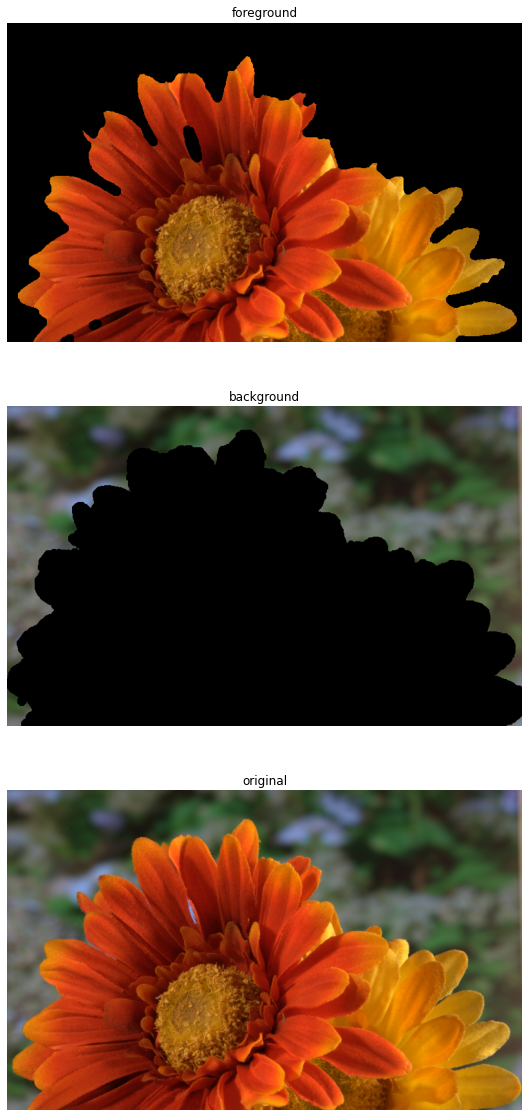

In [63]:
import time
t1 = time.time()
f,b, mask = solve(im,tr,gt,thresh = 10)
t2 = time.time()

In [64]:
plt.imshow(f,astype(np.uint8))

NameError: name 'f' is not defined